# Q4 a to b

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import accuracy_score,confusion_matrix
import seaborn as sns

df = pd.read_csv('credit_card_default.csv')
feature_labels = (df.iloc[0])
feature_labels = (feature_labels.iloc[1:24])
feature_labels =  feature_labels.to_numpy()

df = df.iloc[1:] # remove first row (one with names)
df = df.astype(int) # makes everthing is an int
X = df.drop('Y', axis=1)
y = df['Y']
y.to_numpy()
X.drop(columns=df.columns[0], axis=1, inplace=True)


As there are no missing values and the categorical variables have already been encoded I did not do much processing. I just removed the header and row, extra index column, and split the data in X and y.

With boosting normalizing is not really needed. We still could of course I just do not feel like it.

In [2]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
base_estimator = DecisionTreeClassifier(max_depth=1)  # Decision stump
# Define parameter grid for tuning
param_grid = {
    'learning_rate': [0.4,0.5,1.0]
}
# Create AdaBoost classifier
ada_classifier = AdaBoostClassifier(algorithm='SAMME',estimator=base_estimator, random_state=42)
# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(ada_classifier, param_grid, cv=5)
grid_search.fit(X_train, y_train)
# Get best parameter and score
best_param_AdaBoost = grid_search.best_params_
best_score_AdaBoost = grid_search.best_score_

In [4]:
# Create XGBoost classifier
xgb_classifier = xgb.XGBClassifier(random_state=42)

# Define parameter grid for tuning
param_grid = {
    'learning_rate': [0.4,0.5,1.0]
}

# Perform grid search with 5-fold cross-validation
grid_search = GridSearchCV(xgb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get best parameters and score
best_params_xgb = grid_search.best_params_
best_score_xgb = grid_search.best_score_

In [5]:
print("AdaBoost")
print(best_param_AdaBoost)
print(best_score_AdaBoost)
print("xgb")
print(best_params_xgb)
print(best_score_xgb)

AdaBoost
{'learning_rate': 0.5}
0.82025
xgb
{'learning_rate': 0.4}
0.8073750000000001


# 4c.

In [6]:
# Train final model with best parameters
best_classifier_xgb = xgb.XGBClassifier(**best_params_xgb, random_state=42)
best_classifier_xgb.fit(X_train, y_train)
# Make predictions on test set
y_pred_xgb = best_classifier_xgb.predict(X_test)

# Train final model with best parameters
best_classifier_ada = AdaBoostClassifier(algorithm='SAMME',estimator=base_estimator, **best_param_AdaBoost, random_state=42)
best_classifier_ada.fit(X_train, y_train)
# Make predictions on test set
y_pred_ada = best_classifier_ada.predict(X_test)

# Evaluate accuracy
accuracy = accuracy_score(y_test, y_pred_ada)
print(f"Accuracy_ada: {accuracy}")
accuracy = accuracy_score(y_test, y_pred_xgb)
print(f"Accuracy_xgb: {accuracy}")

Accuracy_ada: 0.8191666666666667
Accuracy_xgb: 0.8086666666666666


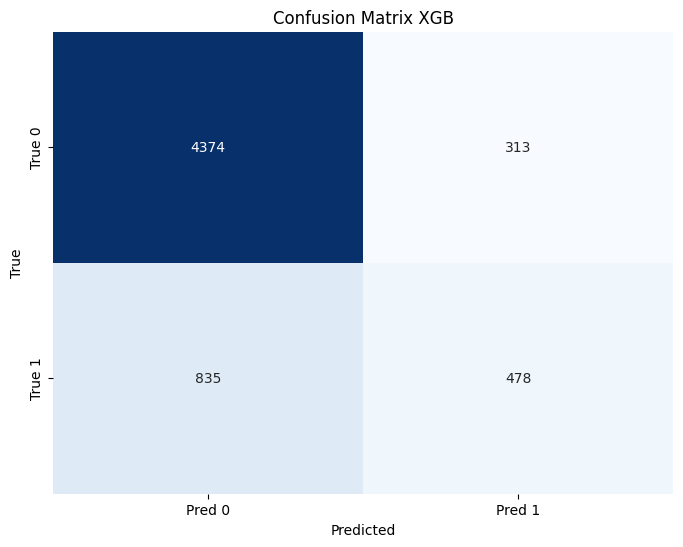

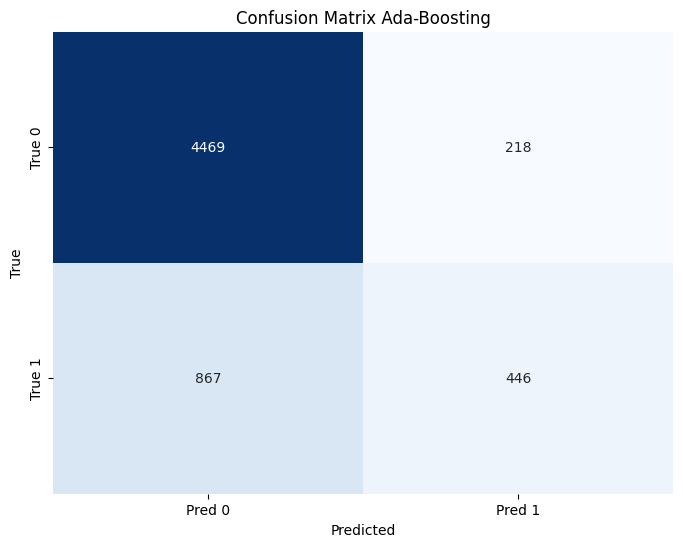

In [7]:
# Compute confusion matrix for y_pred_xgb
cm = confusion_matrix(y_test, y_pred_xgb)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix XGB')
plt.show()

# Compute confusion matrix for y_pred_xgb
cm = confusion_matrix(y_test, y_pred_ada)
# Plot the confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
            xticklabels=['Pred 0', 'Pred 1'], 
            yticklabels=['True 0', 'True 1'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Ada-Boosting')
plt.show()

Note: we used accuracy for an unbalanced data set so the performance is expected to be somewhat poor (you asked us to evaluate on accuracy and not F1 or something like that IDK why).

The data employed a binary variable, default payment (Yes = 1, No = 0). 

The confusion matrix for XGB Shows that the model predicted True more often that Ada-boost and thus has slightly more TP Than ada-boost. That said it did not do a good job actually determining when someone is going to default (had a lot of FP compared to TP). This means even when it predicts some to default they may not. Also It had a lot of FN. This means the model was bad at even identifying if someone was going to have a default payment.



The confusion matrix for ADA-Boost was a bit better but not great. The confusion matrix for Ada-boost Shows that the model had more TP then FN compared to XGB. This is good as it means when it predicts some to default they have a better chance of actually defaulting (which is important). It, Also had a lot of FN. This means the model was also bad at identifying if someone was going to have a default payment.




# 4 d.

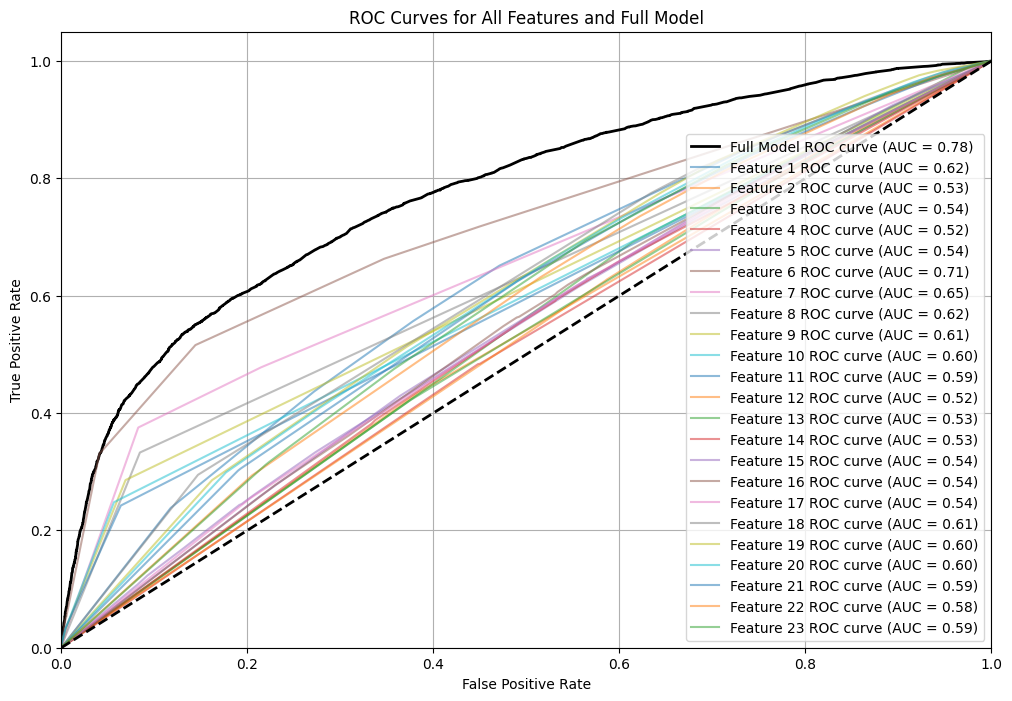

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

# Plot setup
plt.figure(figsize=(12, 8))

# ROC for the full model
y_scores_full = best_classifier_ada.decision_function(X_train)
fpr_full, tpr_full, _ = roc_curve(y_train, y_scores_full)
roc_auc_full = roc_auc_score(y_train, y_scores_full)
plt.plot(fpr_full, tpr_full, color='black', lw=2, 
         label=f'Full Model ROC curve (AUC = {roc_auc_full:.2f})')

# Plot ROC curves for each individual feature
for i, feature_name in enumerate(X.columns):
    feature = X_train.iloc[:, i].values.reshape(-1, 1)
    feature_model = best_classifier_ada
    feature_model.fit(feature, y_train)
    y_scores_feature = feature_model.decision_function(feature)
    fpr_feature, tpr_feature, _ = roc_curve(y_train, y_scores_feature)
    roc_auc_feature = roc_auc_score(y_train, y_scores_feature)
    plt.plot(fpr_feature, tpr_feature, alpha=0.5,
             label=f'Feature {i+1} ROC curve (AUC = {roc_auc_feature:.2f})')

# Plot settings
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Features and Full Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# 4E

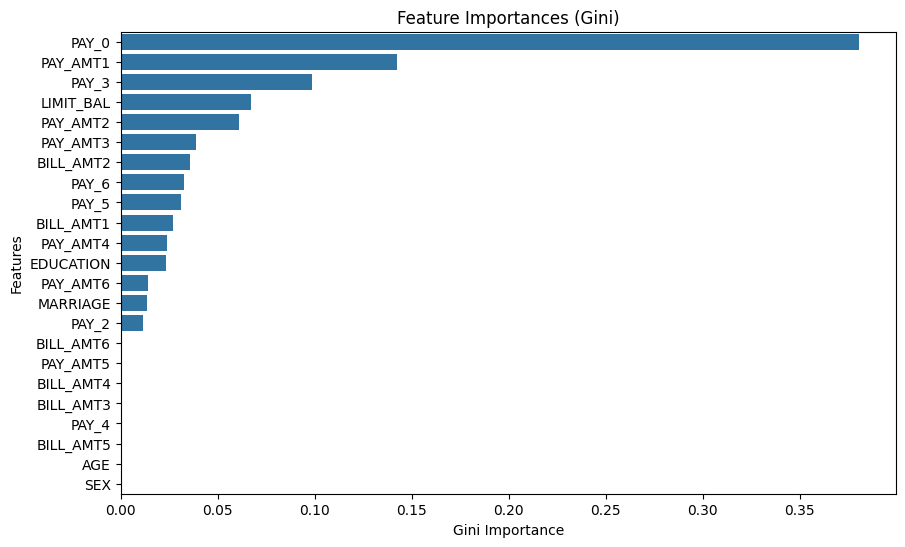

In [9]:
# Train final model with best parameters again (It got changed somewhere and I am to lazy to find out where)
best_classifier_ada = AdaBoostClassifier(algorithm='SAMME',estimator=base_estimator, **best_param_AdaBoost, random_state=42)
best_classifier_ada.fit(X_train, y_train)

model = best_classifier_ada

gini_importance = model.feature_importances_
# Plotting the feature importances
indices_gini = np.argsort(gini_importance)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=gini_importance[indices_gini], y=feature_labels[indices_gini])
plt.xlabel('Gini Importance')
plt.ylabel('Features')
plt.title('Feature Importances (Gini)')
plt.show()

Note I have to use packages as even the STD lib is a collection of packages. I will just assume you do not want me to use skleans built in permutation_importance

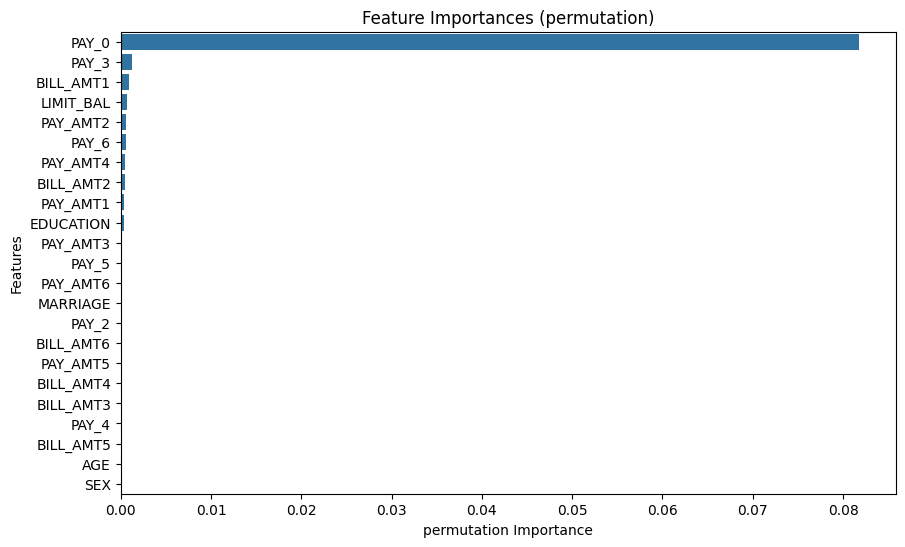

In [10]:
model = best_classifier_ada 
importances = np.zeros(len(feature_labels))
baseline_accuracy = accuracy_score(y_train, model.predict(X_train))
for feature_index in range(len(feature_labels)):
    shuffled_col = np.random.permutation(X_train.iloc[:, feature_index].values)
    X_permuted = X_train.copy()
    X_permuted.iloc[:, feature_index] = shuffled_col
    permuted_accuracy = accuracy_score(y_train, model.predict(X_permuted))
    importances[feature_index] = np.abs(baseline_accuracy - permuted_accuracy)

# Plotting the feature importances
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
sns.barplot(x=importances[indices], y=feature_labels[indices])
plt.xlabel('permutation Importance')
plt.ylabel('Features')
plt.title('Feature Importances (permutation)')
plt.show()

The most important feature is Pay_0 which tracks the repayment status in September. Maybe if some one misses a payment in September it is because they have kids. Therefore having kids might influence credit card default in the future (this is a big stretch). 

ATM payments appear to be the next most important feature. This feature is the amount paid in September. For some reason what someone does in september seems to have the most impact on predicting their risk of default.

Based on the features my guess is shopping habits around different times of years might be influence credit card default in the future.